### Importing all the relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor

In [2]:
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from sklearn.linear_model import LinearRegression
from causalml.inference.meta import LRSRegressor

In [3]:
import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import random

### Setting Data and other variables for Causal ML

In [4]:
df = pd.read_csv("ToyotaCorolla.csv")

In [5]:
#Encoding for categorical variables
df = pd.get_dummies(df, columns = ['FuelType'])

In [6]:
df.head()

,Price,Age,KM,HP,MetColor,Automatic,CC,Doors,Weight,FuelType_CNG,FuelType_Diesel,FuelType_Petrol
0,13500,23,46986,90,1,0,2000,3,1165,0,1,0
1,13750,23,72937,90,1,0,2000,3,1165,0,1,0
2,13950,24,41711,90,1,0,2000,3,1165,0,1,0
3,14950,26,48000,90,0,0,2000,3,1165,0,1,0
4,13750,30,38500,90,0,0,2000,3,1170,0,1,0


In [7]:
#Creating a list for propensity score (probability of receiving treatment over control given the conditions) using random library
e_list = []
for i in range(len(df)):
    e_list.append(random.random())

e = np.array(e_list)

In [8]:
#setting outcome variable
y = df['Price']

#setting independent feature variables
X = df.drop(axis=1, columns=['Price'])

#setting feature - 'Automatic'(a binary column) as treatment flag
w = df['Automatic']

In [9]:
#Based on binary values set in w as above, value = 1 will be treatment set, value =0 will be control set
w_multi = np.array(['treatment' if x==1 else 'control' for x in w])

In [10]:
e_multi = {'treatment': e}

In [11]:
#Setting feature names from the selected dataset
feature_names = X.columns
print(feature_names)

Index(['Age', 'KM', 'HP', 'MetColor', 'Automatic', 'CC', 'Doors', 'Weight',
       'FuelType_CNG', 'FuelType_Diesel', 'FuelType_Petrol'],
      dtype='object')


In [12]:
model_tau = XGBRegressor(importance_type='gain')

# Using XGBRegressor as Base Algorithm

## S Learner

- S-learner uses single estimator
- Uses treatment feature similar to other features
- Expected outcome = E(X) = 𝐸[𝑌 | 𝑋 = 𝑥, 𝑊 = 𝑤_multi]
- CATE = 𝐸[𝑋 = 𝑥, 𝑊 = 1] - 𝐸[𝑋 = 𝑥, 𝑊 = 0]

In [13]:
#base_algo = LGBMRegressor()
#base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(XGBRegressor(), control_name='control')

#Average Treatment Effect
slearner.estimate_ate(X, w_multi, y)

array([49.32465875])

In [14]:
#Treatment effect predictions
slearner_tau = slearner.fit_predict(X, w_multi, y)

##### Method = Auto
- calculates importance based on default implementation of base algo i.e XGB in this case

In [15]:
s_auto_features = slearner.get_importance(X=X, tau=slearner_tau, normalize=True, method='auto', features=feature_names)
s_auto_features

{'treatment': KM                 0.478742
 Age                0.326776
 Weight             0.124593
 CC                 0.037429
 MetColor           0.023305
 HP                 0.006129
 Doors              0.002421
 Automatic          0.000480
 FuelType_Petrol    0.000126
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 dtype: float64}

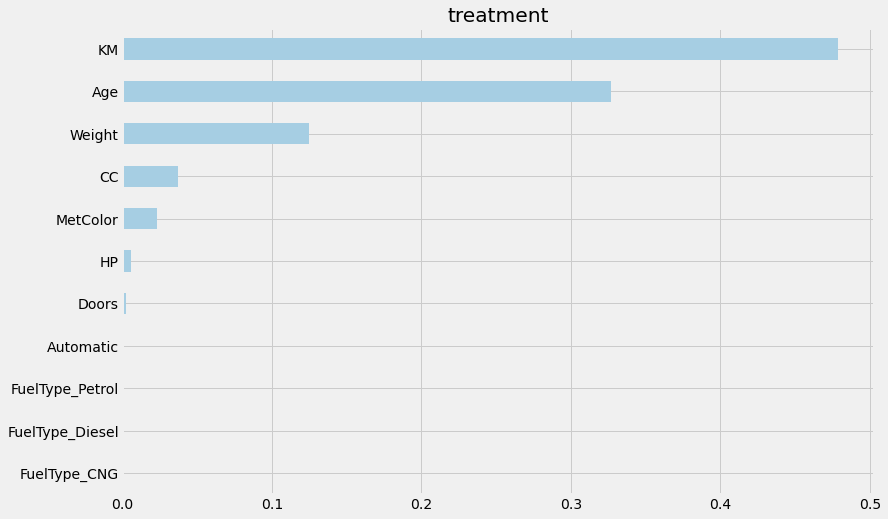

In [16]:
#Plotting above feature importance result
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='auto', features=feature_names)

##### Method = Permutation
- calculates importance based on MDA on permuting feature column

In [17]:
start_time = time.time()

s_perm_features = slearner.get_importance(X=X, tau=slearner_tau, method='permutation', features=feature_names, random_state=42)

print(s_perm_features)
print("Elapsed time: %s seconds" % (time.time() - start_time))

{'treatment': KM                 1.003698
Age                0.636041
Weight             0.234144
MetColor           0.047839
CC                 0.027998
HP                 0.007905
Doors              0.002607
FuelType_Petrol    0.000263
FuelType_CNG       0.000000
FuelType_Diesel    0.000000
Automatic         -0.000463
dtype: float64}
Elapsed time: 0.2211472988128662 seconds


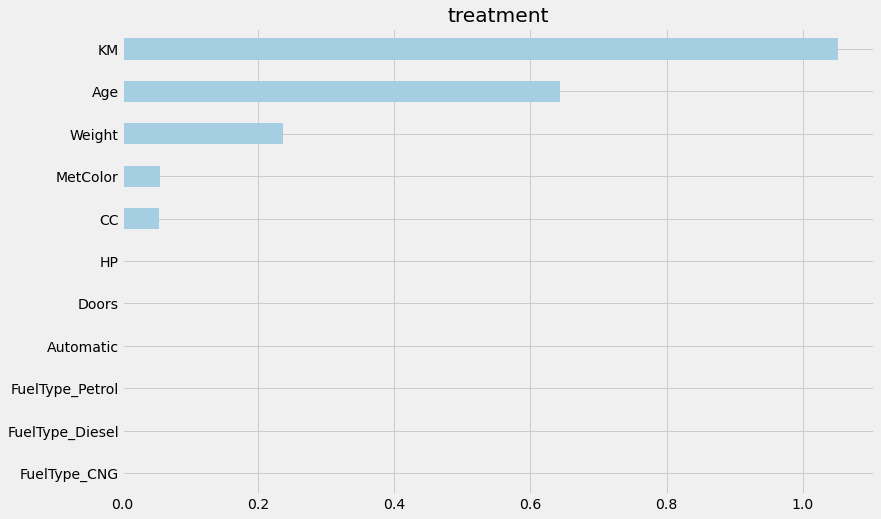

In [18]:
#Plotting above feature importance result
slearner.plot_importance(X=X, tau=slearner_tau, normalize=True, method='permutation', features=feature_names)

### Permutation Importance (sklearn)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

#### Test Set

In [20]:
start_time = time.time()

perm_imp_test = permutation_importance(estimator=model_tau_fit, X=X_test, y=y_test, random_state=42).importances_mean

pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.33821678161621094 seconds


In [21]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

KM                 1.042170
Age                0.592747
Weight             0.272337
MetColor           0.045966
CC                 0.027537
HP                 0.011791
Doors              0.006305
FuelType_Petrol    0.000412
FuelType_CNG       0.000162
FuelType_Diesel    0.000000
Automatic         -0.003697
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

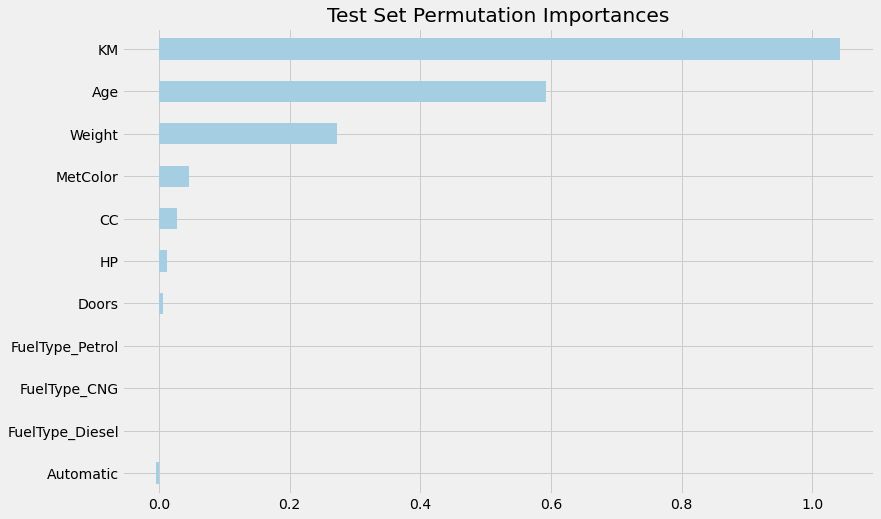

In [22]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

#### Training Set

In [23]:
perm_imp_train = permutation_importance(estimator=model_tau_fit, X=X_train, y=y_train, random_state=42).importances_mean

pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

KM                 1.076775
Age                0.675190
Weight             0.283441
MetColor           0.045313
CC                 0.040216
HP                 0.015217
Doors              0.004614
Automatic          0.001955
FuelType_Petrol    0.000172
FuelType_CNG       0.000115
FuelType_Diesel    0.000000
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

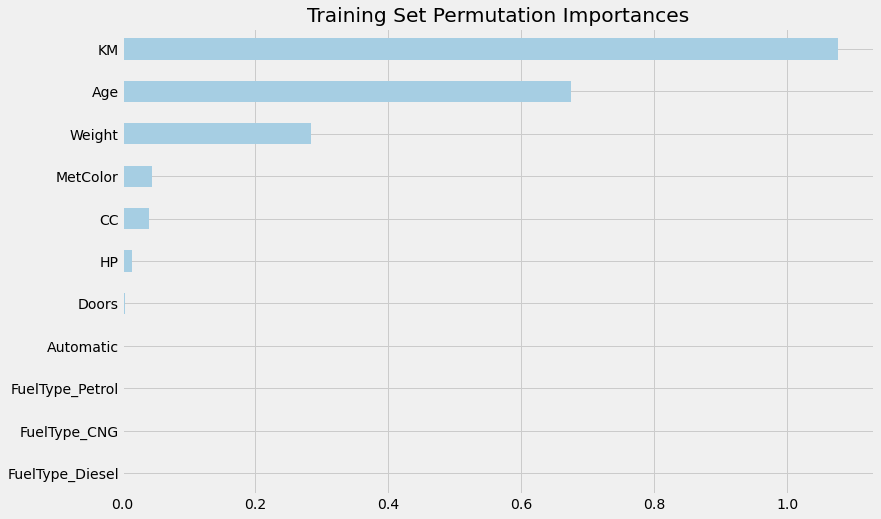

In [24]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

### Shapley Values

In [25]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment': array([[-1.71983466e+02, -1.31980882e+02,  5.97878632e+01, ...,
          0.00000000e+00,  0.00000000e+00,  2.33360436e-01],
        [-2.22650248e+02,  2.47211086e+01,  6.14068852e+01, ...,
          0.00000000e+00,  0.00000000e+00,  3.76918213e-01],
        [-1.67632432e+02, -9.85602992e+01,  5.97686377e+01, ...,
          0.00000000e+00,  0.00000000e+00,  2.31349397e-01],
        ...,
        [ 6.33487885e+01, -7.35137530e+01,  4.86491840e+00, ...,
          0.00000000e+00,  0.00000000e+00, -1.16429317e-01],
        [ 5.82905369e+01, -3.48378174e+01,  5.01154568e+00, ...,
          0.00000000e+00,  0.00000000e+00, -1.24144826e-01],
        [ 4.46690151e+01, -3.42195222e+01, -2.99505706e+00, ...,
          0.00000000e+00,  0.00000000e+00, -1.81449306e-01]])}

In [26]:
np.mean(np.abs(shap_slearner['treatment']),axis=0)

array([ 87.58402686, 145.02555047,   5.04123771,  25.11967425,
         0.87999097,  11.64900155,   4.17750661,  52.81720003,
         0.        ,   0.        ,   0.30489656])

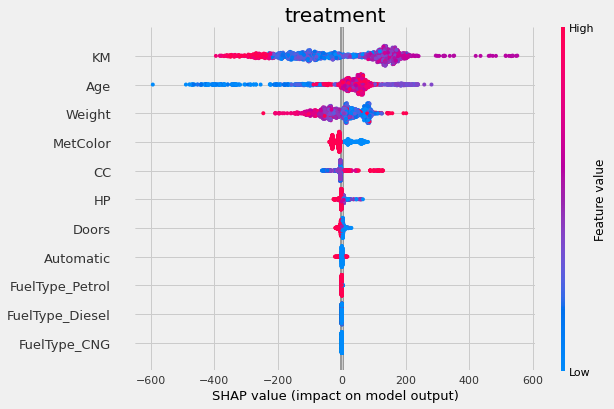

In [27]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

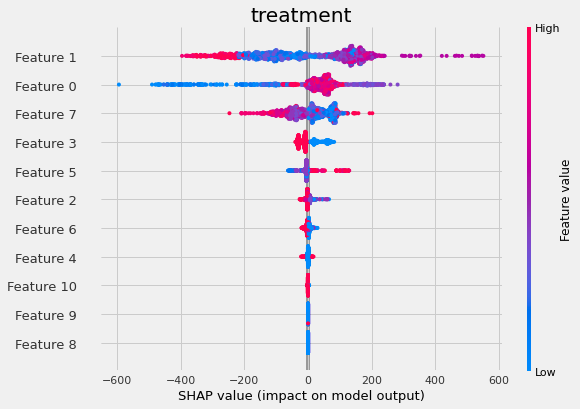

In [28]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

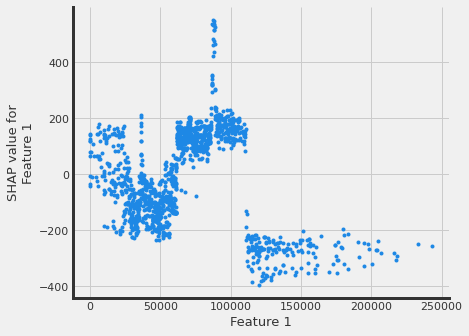

In [29]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

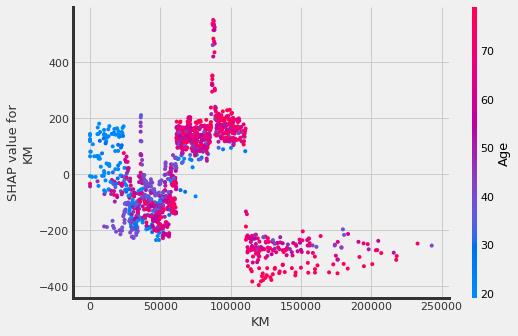

In [30]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment',
                              feature_idx='KM',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


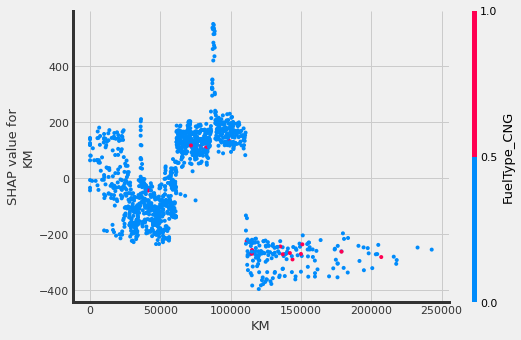

In [31]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=8,
                              shap_dict=shap_slearner, 
                              features=feature_names)

## T Learner

- Used when base learners are tree based
- Expected outcome = 
    - E0(X) = E[Y(0)|X=x]
    - E1(X) = E[Y(1)|X=x]
- CATE = 𝐸1[𝑋 = 𝑥] - 𝐸0[𝑋 = 𝑥]

In [32]:
tlearner = BaseTRegressor(XGBRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([416.03414874]), array([337.21618694]), array([494.85211055]))

In [33]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

##### Method = Auto
- calculates importance based on default implementation of base algo i.e XGB in this case

In [34]:
t_auto_features = tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)
t_auto_features

{'treatment': Age                0.309918
 KM                 0.227939
 HP                 0.219012
 Weight             0.178054
 Doors              0.023968
 CC                 0.020967
 MetColor           0.012106
 FuelType_Petrol    0.007675
 Automatic          0.000362
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 dtype: float64}

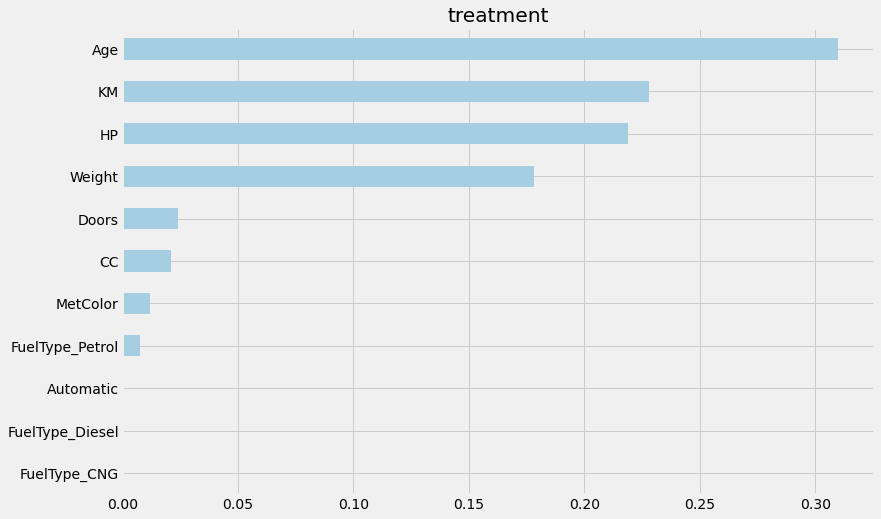

In [35]:
tlearner.plot_importance(X=X, tau=tlearner_tau, normalize=True, method='auto', features=feature_names)

##### Method = Permutation
- calculates importance based on MDA on permuting feature column

In [36]:
t_perm_features = tlearner.get_importance(X=X, tau=tlearner_tau, method='permutation', features=feature_names, random_state=42)
t_perm_features

{'treatment': Age                0.600937
 Weight             0.462695
 KM                 0.278788
 HP                 0.176682
 FuelType_Petrol    0.030534
 Doors              0.020778
 CC                 0.016202
 MetColor           0.006808
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 Automatic         -0.000378
 dtype: float64}

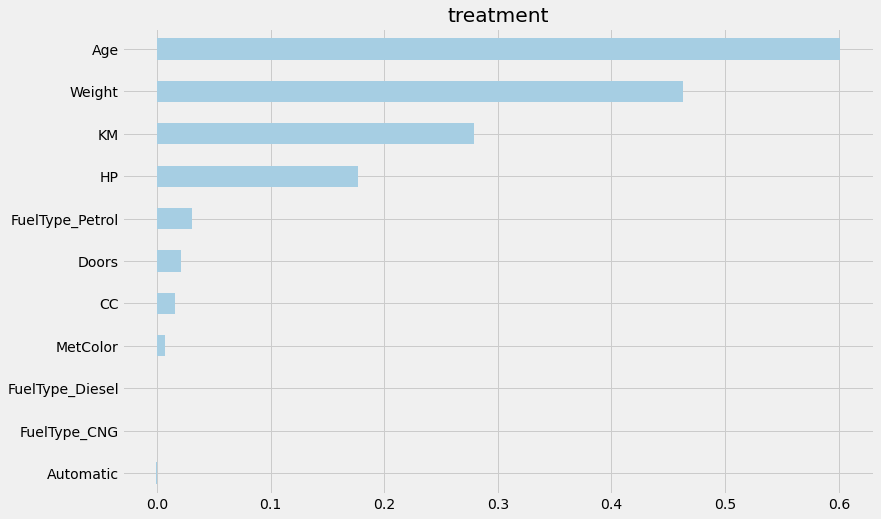

In [37]:
tlearner.plot_importance(X=X, tau=tlearner_tau, method='permutation', features=feature_names, random_state=42)

### Permutation Importance (sklearn)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)

model_tau_fit = model_tau.fit(X_train, y_train)

#### Test Set

In [39]:
start_time = time.time()

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.4128108024597168 seconds


In [40]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Age                0.819075
KM                 0.310118
HP                 0.284848
Weight             0.228907
CC                 0.051432
Doors              0.021376
FuelType_Petrol    0.014331
MetColor           0.004400
FuelType_CNG       0.001681
Automatic          0.000152
FuelType_Diesel    0.000000
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

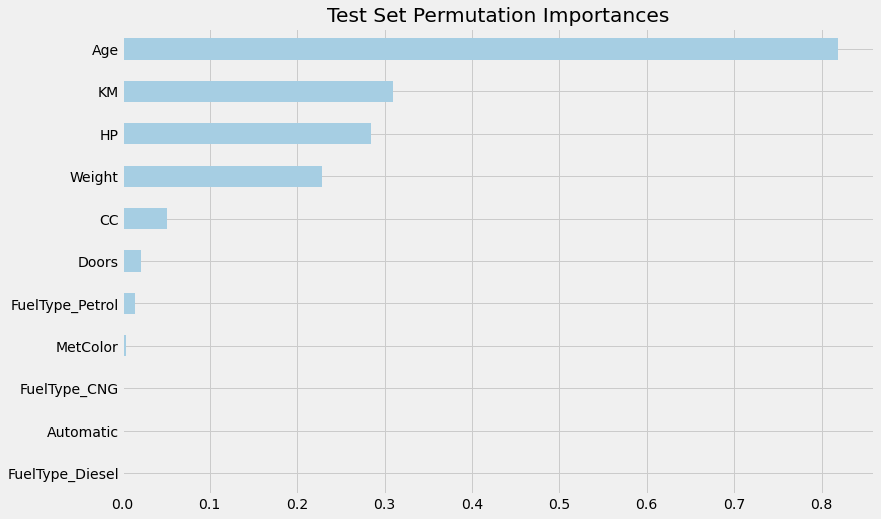

In [41]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [42]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment': array([[2122.64394124,   11.1368951 ,  555.53750398, ...,    0.        ,
            0.        , -139.50387882],
        [1950.01774098,  245.62642826,  538.71697137, ...,    0.        ,
            0.        , -199.10609186],
        [1509.49319521,   11.06719457,  548.40408713, ...,    0.        ,
            0.        , -148.57026039],
        ...,
        [-137.86959012,  637.14196749,  287.61497734, ...,    0.        ,
            0.        ,   16.42911521],
        [-118.67537352,  755.27891071,  310.92460994, ...,    0.        ,
            0.        ,   18.48072412],
        [-110.96350936,  895.03128322,  -87.34530775, ...,    0.        ,
            0.        ,   19.57225172]])}

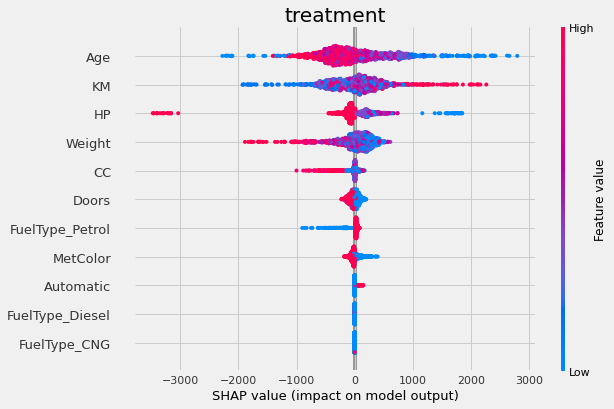

In [43]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

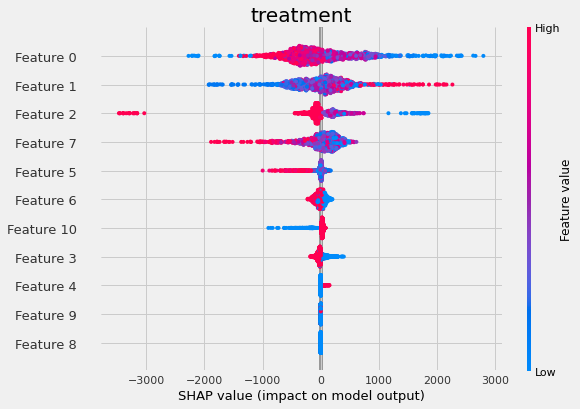

In [44]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(X=X, shap_dict=shap_tlearner)

## X Learner

- It is built on tree learner and is more suited for smaller treatment group
- It uses information from the control group to derive better estimators for the treatment group and vice versa
- Expected outcome = 
    - E0(X) = E[Y(0)|X=x]
    - E1(X) = E[Y(1)|X=x]
- Impute counterfactuals
    - treatment effect on treatment set based on control outcomes (D1)
    - treatment effect on control set based on treatment outcomes (D0)
- Estimate CATE in two ways based on D1 and D0 and then take average estimates

In [45]:
xlearner = BaseXRegressor(XGBRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y, p=e_multi)

(array([279.69695285]), array([222.74528949]), array([336.6486162]))

In [46]:
xlearner_tau = xlearner.predict(X, w_multi, y, p=e_multi)

##### Method = Auto
- calculates importance based on default implementation of base algo i.e XGB in this case

In [47]:
x_auto_features = xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)
x_auto_features

{'treatment': KM                 0.313069
 Age                0.292381
 HP                 0.233857
 Weight             0.107540
 Doors              0.021831
 MetColor           0.018863
 FuelType_Petrol    0.005804
 CC                 0.005700
 Automatic          0.000732
 FuelType_Diesel    0.000223
 FuelType_CNG       0.000000
 dtype: float64}

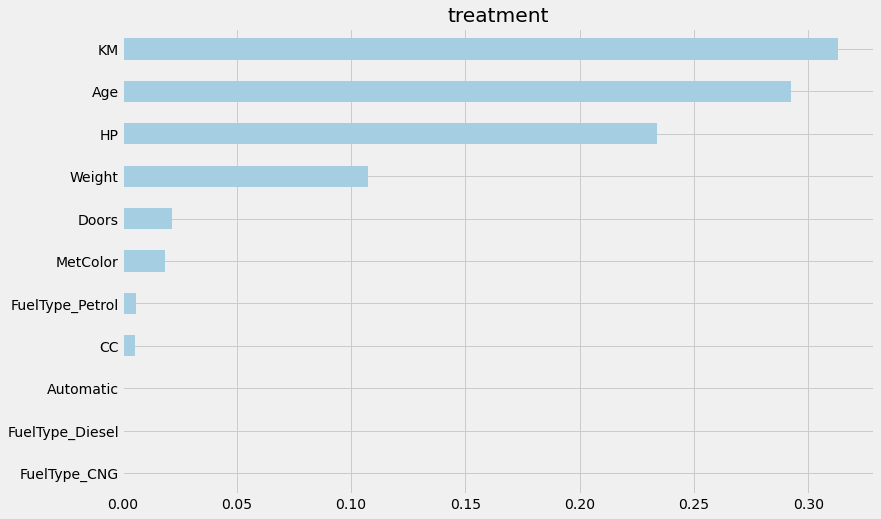

In [48]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

##### Method = Permutation
- calculates importance based on MDA on permuting feature column

In [49]:
x_perm_features = xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)
x_perm_features

{'treatment': Age                0.739015
 KM                 0.364411
 Weight             0.302241
 HP                 0.284338
 Doors              0.017664
 FuelType_Petrol    0.017164
 MetColor           0.014783
 CC                 0.010775
 Automatic          0.000403
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 dtype: float64}

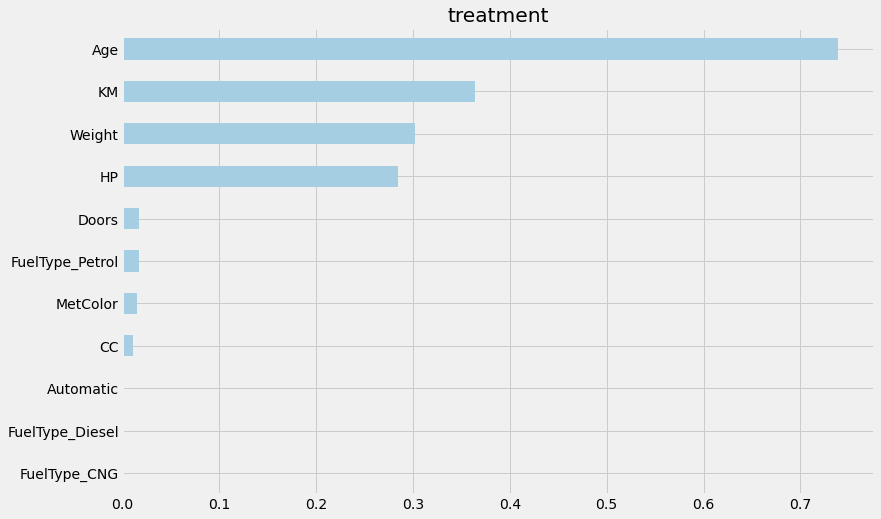

In [50]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Permutation Importance (sklearn)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)

model_tau_fit = model_tau.fit(X_train, y_train)

#### Test Set

In [52]:
start_time = time.time()

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.5464022159576416 seconds


In [53]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Age                0.787449
KM                 0.346956
Weight             0.328708
HP                 0.173238
FuelType_CNG       0.014553
MetColor           0.011388
CC                 0.005893
Doors              0.005372
FuelType_Petrol    0.002972
FuelType_Diesel    0.000000
Automatic         -0.001069
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

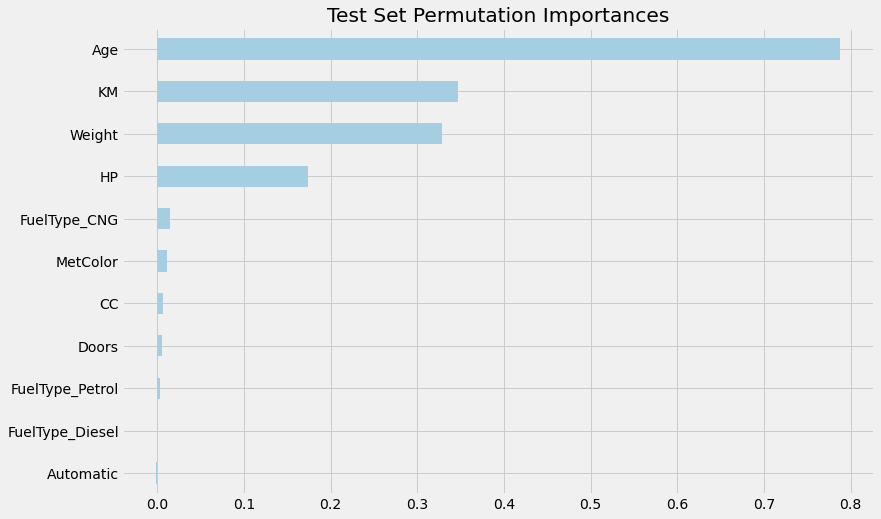

In [54]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [55]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment': array([[ 1.44342684e+03,  9.83442118e+01,  4.97311107e+02, ...,
          0.00000000e+00,  2.79445393e+00, -2.08807462e+02],
        [ 1.15017827e+03,  3.05099229e+02,  5.24704375e+02, ...,
          0.00000000e+00,  2.38432725e+00, -2.21121858e+02],
        [ 1.08153464e+03,  1.09150651e+02,  4.76493897e+02, ...,
          0.00000000e+00,  2.79445393e+00, -2.37587080e+02],
        ...,
        [ 8.93323334e+01,  7.32196949e+02,  3.38999227e+02, ...,
          0.00000000e+00, -1.74237695e+00,  1.71178189e+01],
        [ 1.18886284e+02,  5.96996581e+02,  3.43305524e+02, ...,
          0.00000000e+00, -3.67560335e-01,  1.67046185e+01],
        [-5.76174037e+00,  6.78585240e+02, -1.78050416e+02, ...,
          0.00000000e+00, -4.81462910e-01,  1.07762676e+01]])}

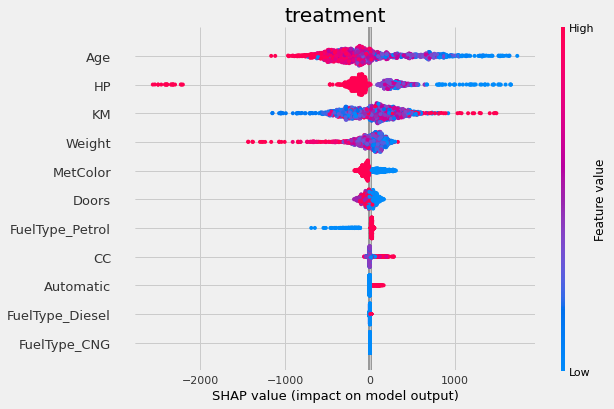

In [56]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

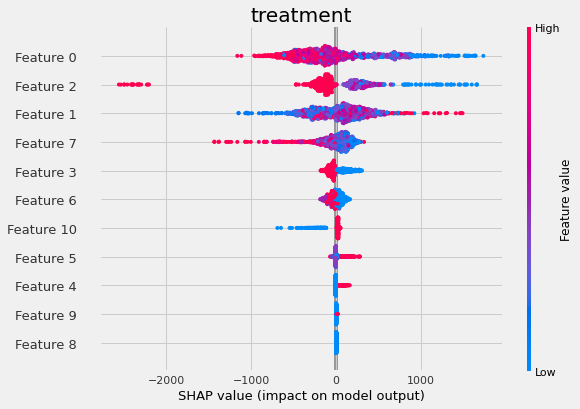

In [57]:
# shap_dict specified
xlearner.plot_shap_values(X=X, shap_dict=shap_xlearner)

## R Learner

- Uses cross validations

In [58]:
rlearner = BaseRRegressor(XGBRegressor(), control_name='control')
rlearner_tau = rlearner.fit_predict(X, w_multi, y, p=e_multi)

##### Method = Auto
- calculates importance based on default implementation of base algo i.e XGB in this case

In [59]:
r_auto_features = rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)
r_auto_features

{'treatment': KM                 0.355098
 Age                0.246170
 Weight             0.232925
 HP                 0.052774
 CC                 0.042177
 Doors              0.040053
 MetColor           0.014777
 FuelType_Petrol    0.011958
 Automatic          0.004068
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 dtype: float64}

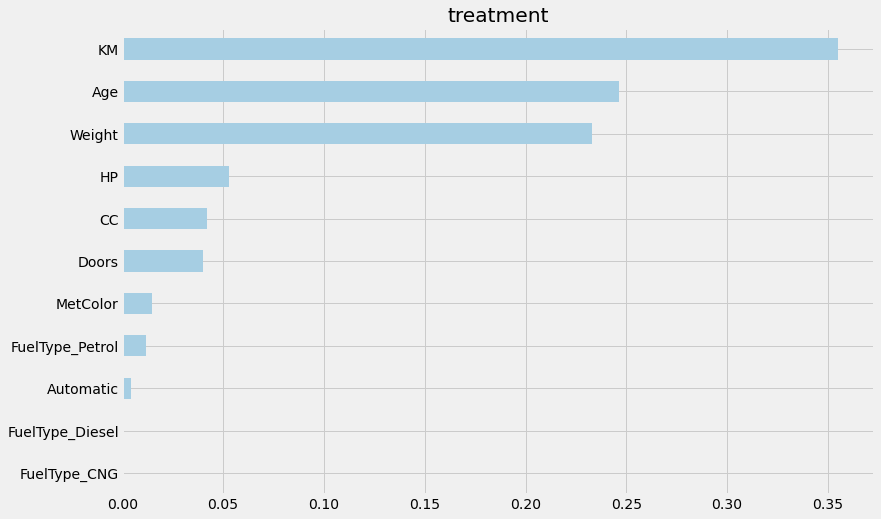

In [60]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='auto', 
                         features=feature_names)

##### Method = Permutation
- calculates importance based on MDA on permuting feature column

In [61]:
r_perm_features = rlearner.get_importance(X=X, 
                        tau=rlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)
r_perm_features

{'treatment': Age                0.211692
 KM                 0.155355
 Weight             0.154866
 HP                 0.142137
 CC                 0.032793
 Doors              0.018725
 MetColor           0.002531
 FuelType_CNG       0.000000
 FuelType_Diesel    0.000000
 Automatic         -0.000005
 FuelType_Petrol   -0.009209
 dtype: float64}

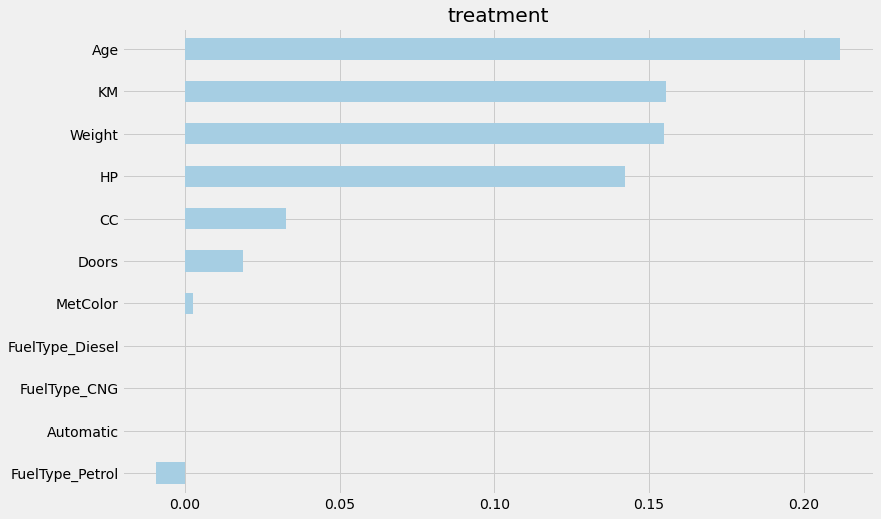

In [62]:
rlearner.plot_importance(X=X, 
                         tau=rlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

### Permutation Importance (sklearn)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, rlearner_tau, test_size=0.3, random_state=42)

model_tau_fit = model_tau.fit(X_train, y_train)

#### Test Set

In [64]:
start_time = time.time()

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.3862323760986328 seconds


In [65]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

KM                 0.589428
Age                0.463651
HP                 0.339462
CC                 0.180701
Doors              0.095560
Weight             0.071264
FuelType_CNG       0.051625
MetColor           0.045745
FuelType_Petrol    0.009981
FuelType_Diesel    0.000000
Automatic         -0.002877
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

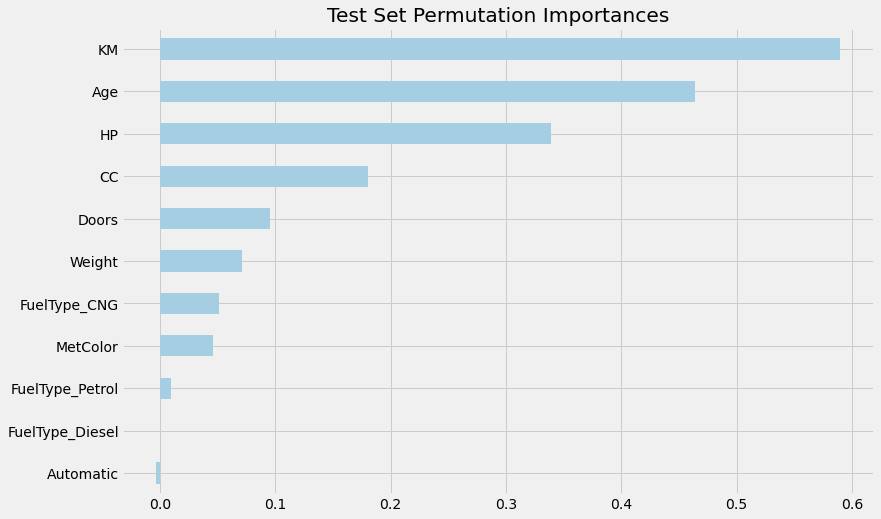

In [66]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

### Shapley Values

In [67]:
shap_rlearner = rlearner.get_shap_values(X=X, tau=rlearner_tau)
shap_rlearner

{'treatment': array([[ 188.98610513,  263.58467943,   -6.41664851, ...,    0.        ,
            0.        , -332.06949346],
        [ 175.11648619,  543.84090495,    7.56161872, ...,    0.        ,
            0.        , -365.53519421],
        [  92.03680253,  258.89045715,  -17.47960722, ...,    0.        ,
            0.        , -335.28314699],
        ...,
        [ 561.3502691 ,  341.7555479 ,  116.79205151, ...,    0.        ,
            0.        ,    9.74658999],
        [ 519.04713748,  689.03473697,  117.33590119, ...,    0.        ,
            0.        ,   20.90323543],
        [ 355.22526382,  951.47268497,  -34.98099169, ...,    0.        ,
            0.        ,    5.39436899]])}

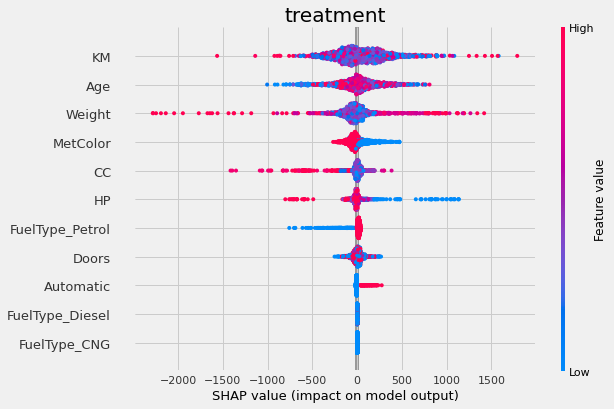

In [68]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, tau=rlearner_tau, features=feature_names)

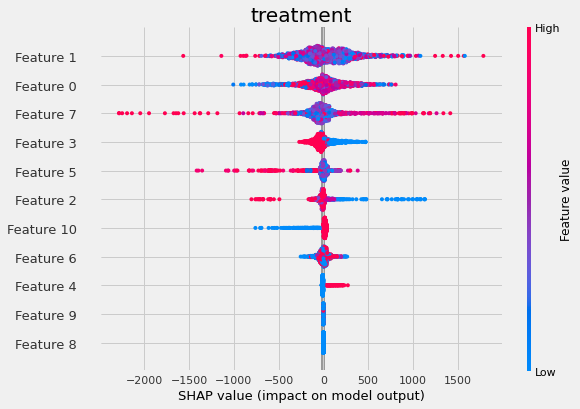

In [69]:
# with providing shap_dict
rlearner.plot_shap_values(X=X, shap_dict=shap_rlearner)

## Conclusion

### Based on Feature Importance

- S-Learner
    - Auto Method gives Age, Weight, CC, Metal Color higher importance.
    - Permutation gives same features high importance with the exception of Metal Color getting slightly higher importance than CC.
- T-Learner
    - Auto Method gives KM, HP, Weight and Doors higher importance.
    - Permutation Method gives Weight, KM, HP and FuelType_Petrol higher importance in given order.
- X-Learner
    - Auto Method gives Age, HP, Weight and Doors higher importance in given order.
    - Permutation Method gives KM, Weight, HP and FuelType_Petrol higher importance in given order.
- R-Learner
    - Auto Method gives Age, Weight, HP and Doors higher importance in given order.
    - Permutation Method gives KM, Doors, Weight and HP higher importance in given order.

### Based on Permutation Importance

- S-Learner
    - Both training and test set suggest KM, Age and Weight as important features after permuting them.
- T-Learner
    - Age, KM, HP and Weight seem to have importance after permuting them. Doors shows a very slight importance as well.
- X-Learner
    - Age, KM, Weight and HP seem to have importance after permuting them. 
- R-Learner
    - KM, Age, HP and Weight seem to have importance after permuting them. Slight importance is shown by doors and Metal color as well.

### Based on Shapley Values

- S-Learner
    - We can see clusters around KM, Age and Weight suggesting that they have influence on outcome variable in case they are modified or changed.
- T-Learner
    - We can see clusters around Age, KM, HP and Weight suggesting that they have influence on outcome variable in case they are modified or changed. Even doors show slight influence on price with some clusters in its shapley plots.
- X-Learner
    - We can see clusters around Age, KM, Weight and HP suggesting that they have influence on outcome variable in case they are modified or changed. 
- R-Learner
    - We can see clusters around KM, Age, HP and Weight suggesting that they have influence on outcome variable in case they are modified or changed. Even doors and metal color show slight influence on price with some clusters in its shapley plots.

Thus from the above we can see that, all the four learners give importance to more or less same features, with slight deviations in their preference order.

## Calculating ITE and CATE

In [70]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=w, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=w, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=w, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=w, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=w, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=w, y=y)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

The max_iter was reached which means the coef_ did not converge


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


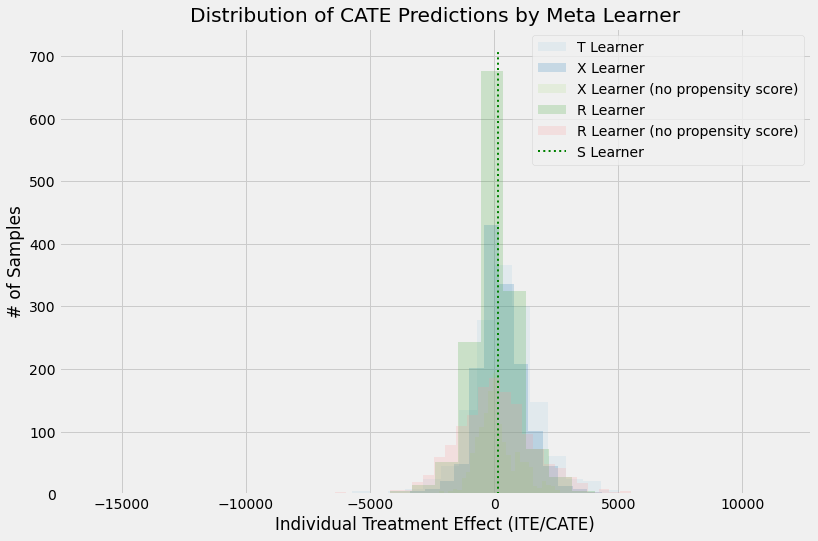

In [71]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()